In [117]:
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns     #seaborn for figure
from statsmodels.graphics.tsaplots import plot_acf  #acf figure
from statsmodels.tsa.stattools import adfuller as ADF  #test stability
from statsmodels.graphics.tsaplots import plot_pacf    #pacf figure
from statsmodels.stats.diagnostic import acorr_ljungbox    #test white noise
from statsmodels.tsa.arima_model import ARIMA
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors

## Data Preprocessing

In [2]:
data= pd.read_csv('Walmart.csv')
data.head()
data_a=data.copy()

In [3]:
data_a['Date'] = pd.to_datetime(data_a['Date'])
data_a['Year'] = data_a['Date'].dt.year
data_a['Month'] = data_a['Date'].dt.month
data_a['Day'] = data_a['Date'].dt.day
data_a.drop('Date',axis=1,inplace=True)

<AxesSubplot:>

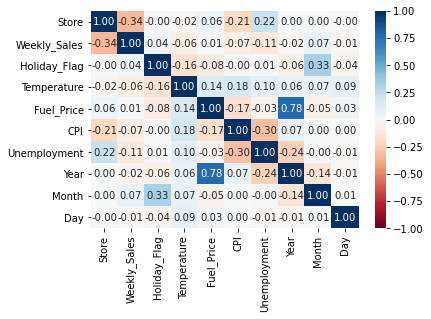

In [4]:
corr=data_a.corr()
sns.heatmap(corr, annot=True, cmap="RdBu",vmin=-1,vmax=1,fmt=".2f")

Text(0.5, 1.0, 'Average Weekly Sales by Month for Three Years')

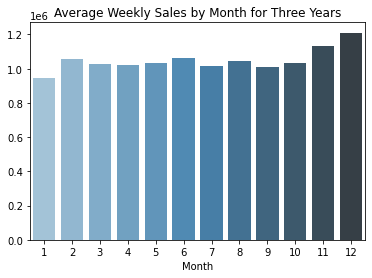

In [5]:
#Which months have the highest weekly sales?
result = data_a.groupby('Month')['Weekly_Sales'].mean()
sns.barplot(x = result.index, y = result.values,palette='Blues_d').set_title('Average Weekly Sales by Month for Three Years')

In [6]:
# Which store had the highest weekly sales in 2010?
data2010 = data_a[data_a.Year==2010]
data2010[data2010.Weekly_Sales == data2010.Weekly_Sales.max()]

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day
1905,14,3818686.45,0,30.59,3.141,182.54459,8.724,2010,12,24


In [7]:
#drop Date
data=data[['Store','Weekly_Sales','Holiday_Flag','Temperature','Fuel_Price','CPI','Unemployment']]

## outlier detection

In [130]:
#the store doesn't matter the outlier, so we neglect store column when do outlier detection
data_out_dete = data[['Weekly_Sales','Holiday_Flag','Temperature','Fuel_Price','CPI','Unemployment']]
#To improve the accuracy, we need to normalize the data
def minmax_norm(df):
    return (df - df.min()) / ( df.max() - df.min())

data_out_dete = minmax_norm(data_out_dete)

In [144]:
#here we apply the dense based method
seed(1)
outlier_detection = DBSCAN(min_samples=3,eps=0.2)
clusters = outlier_detection.fit_predict(data_out_dete)
list(clusters).count(-1)#outlier will labled as -1

24

## Feature Selection

In [8]:
#drop selected feature
data2=data[['Store','Weekly_Sales','Holiday_Flag','Temperature','CPI','Unemployment']]

## Model

In [9]:
X2 = data2.drop(['Weekly_Sales'],axis=1)
y2 = data2['Weekly_Sales']

In [16]:
X = data.drop(['Weekly_Sales'],axis=1)
y = data['Weekly_Sales']

In [17]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
# summarize the shape of the training dataset
print(X.shape, y.shape)
# identify outliers in the training dataset
iso = IsolationForest(contamination=0.1,random_state=0)
yhat = iso.fit_predict(X)
# select all rows that are not outliers
mask = yhat != -1

(6435, 6) (6435,)


In [20]:
X2,y2=X2[mask],y2[mask]

In [21]:
X2_train,X2_test,Y2_train,Y2_test = train_test_split(X2,y2,test_size=0.3,random_state=0)

In [18]:
str(yhat.tolist()).count("-1")

644

In [19]:
X,y=X[mask],y[mask]

In [23]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.3,random_state=0)

In [24]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
transformer = ColumnTransformer(transformers=[('tf',OneHotEncoder(sparse=False,drop='first'),['Store'])],remainder='passthrough')

In [25]:
X_train= transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

In [26]:
X2_train= transformer.fit_transform(X2_train)
X2_test = transformer.transform(X2_test)

In [27]:
X_train

array([[  0.       ,   0.       ,   0.       , ...,   3.808    ,
        131.0983226,   5.621    ],
       [  0.       ,   0.       ,   0.       , ...,   4.186    ,
        138.9117   ,   8.693    ],
       [  0.       ,   0.       ,   0.       , ...,   3.417    ,
        220.6319358,   6.623    ],
       ...,
       [  0.       ,   0.       ,   0.       , ...,   2.85     ,
        181.8657537,   8.899    ],
       [  0.       ,   0.       ,   0.       , ...,   2.72     ,
        211.4713286,   8.163    ],
       [  0.       ,   0.       ,   0.       , ...,   2.81     ,
        136.4928214,   8.433    ]])

In [28]:
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

def pred_model(model,X_train,Y_train,X_test,Y_test):
    c = model()
    c.fit(X_train,Y_train)
    y_pred = c.predict(X_test)
    print(model)
    print(f'MSE: {mean_squared_error(Y_test,y_pred)}')
    print(f'R2 : {r2_score(Y_test,y_pred)}')
    

In [29]:
pred_model(Lasso,X_train,Y_train,X_test,Y_test)

<class 'sklearn.linear_model._coordinate_descent.Lasso'>
MSE: 24832259717.074722
R2 : 0.9239459465088411


D:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45827975929038.734, tolerance: 127056342596.07875
  model = cd_fast.enet_coordinate_descent(


In [30]:
pred_model(Ridge,X_train,Y_train,X_test,Y_test)

<class 'sklearn.linear_model._ridge.Ridge'>
MSE: 24965524305.471653
R2 : 0.923537795488761


In [31]:
pred_model(LinearRegression,X_train,Y_train,X_test,Y_test)

<class 'sklearn.linear_model._base.LinearRegression'>
MSE: 24850572269.09018
R2 : 0.9238898604407018


In [32]:
pred_model(LinearRegression,X2_train,Y2_train,X2_test,Y2_test)

<class 'sklearn.linear_model._base.LinearRegression'>
MSE: 24998528929.853256
R2 : 0.9234367118380271


In [33]:
pred_model(Lasso,X2_train,Y2_train,X2_test,Y2_test)

<class 'sklearn.linear_model._coordinate_descent.Lasso'>
MSE: 24972676366.125637
R2 : 0.9235158907885949


D:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46351657392073.28, tolerance: 127056342596.07875
  model = cd_fast.enet_coordinate_descent(


In [34]:
ANN=MLPRegressor(hidden_layer_sizes=(100,100),random_state=0)
ANN.fit(X_train,Y_train)
y_pred = ANN.predict(X_test)
print(ANN)
print(f'MSE: {mean_squared_error(Y_test,y_pred)}')
print(f'R2 : {r2_score(Y_test,y_pred)}')
ANN.score(X_test,Y_test)

MLPRegressor(hidden_layer_sizes=(100, 100), random_state=0)
MSE: 363614819010.7572
R2 : -0.11364737685177251


D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


-0.11364737685177251

In [35]:
#random forest
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, Y_train)
y_pred = regr.predict(X_test)
print(regr)
print(f'MSE: {mean_squared_error(Y_test,y_pred)}')
print(f'R2 : {r2_score(Y_test,y_pred)}')
#regr.score(X_test,Y_test)

RandomForestRegressor(max_depth=2, random_state=0)
MSE: 248915075176.49377
R2 : 0.2376448757415378


## Time Series Model For Procasting

In [38]:
#time series analysis on weekly sales
%pylab inline
plt.rcParams['axes.unicode_minus'] = False #display minus sign
pylab.rcParams['figure.figsize'] = (10, 6)   #set figure size
sns.set(color_codes=True) #seaborn set backround

Populating the interactive namespace from numpy and matplotlib


<AxesSubplot:>

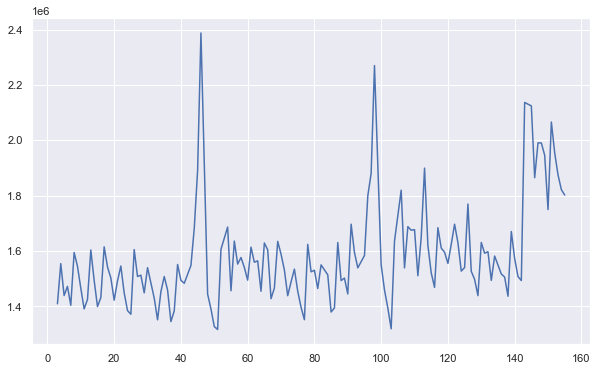

In [46]:
data_sales = y[1:144]#for a single store
data_sales.plot()

<ipython-input-75-f504462dbdaf>:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(data_sales).show()


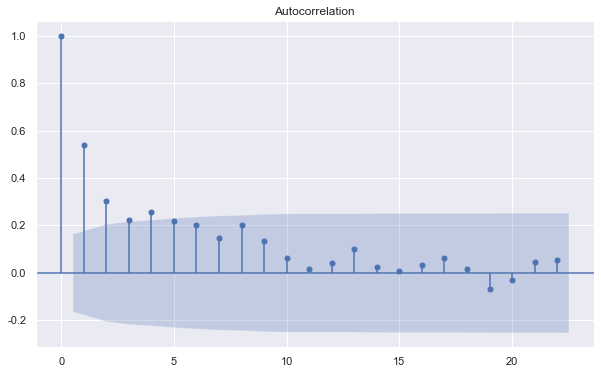

In [75]:
plot_acf(data_sales).show()

In [70]:
print(ADF(data_sales))

(-6.38690409943955, 2.1530338511330616e-08, 0, 142, {'1%': -3.477261624048995, '5%': -2.8821181874544233, '10%': -2.5777431104939494}, 3433.252825986396)


Since the P-value is 3.574784731013673e-05, lower than 5% significance, so the time series is stable.

In [66]:
print(acorr_ljungbox(data_sales,lags=1))

(array([42.70169018]), array([6.37571763e-11]))


D:\Anaconda\lib\site-packages\statsmodels\stats\diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


Since the P-value is 6.37571763e-11, lower than 5% significance, so the time series is non white noise.

<AxesSubplot:>

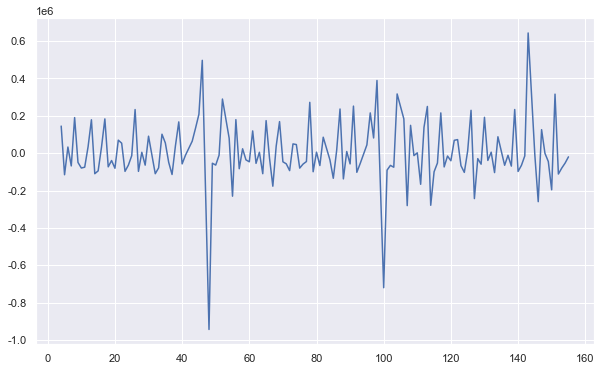

In [48]:
#do first-order difference
D_data_sales = data_sales.diff().dropna()   
D_data_sales.plot() #时序图

<ipython-input-74-c8292e42a6c8>:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_pacf(data_sales).show()


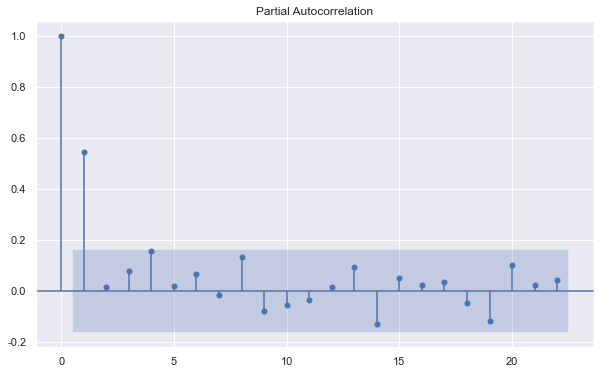

In [74]:
plot_pacf(data_sales).show()

<ipython-input-78-d913ea6905ce>:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(D_data_sales).show()


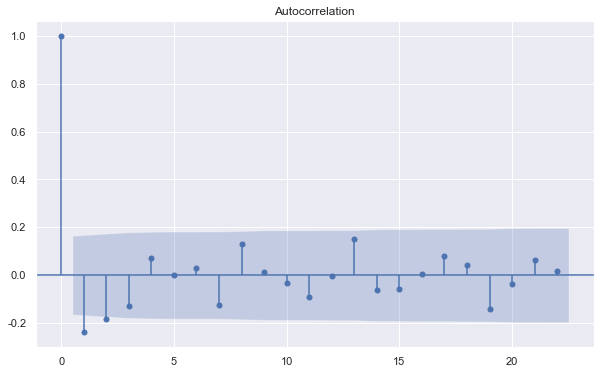

In [78]:
plot_acf(D_data_sales).show()

<ipython-input-79-aba8aa7a15d2>:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_pacf(D_data_sales).show()


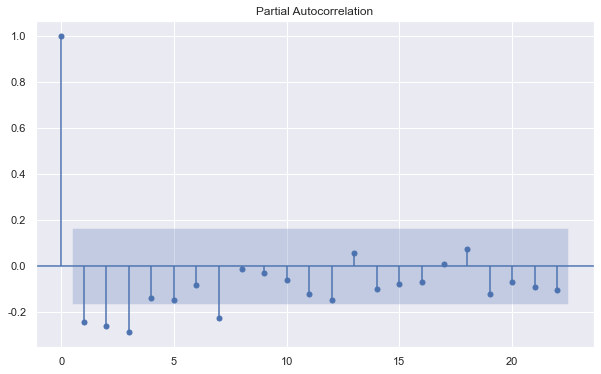

In [79]:
plot_pacf(D_data_sales).show()

Combine the acf and pacf, we can assume that the model is ARIMA(2,0,0), since the acf decays, and the pacf turns 0 after 2.

In [84]:
model = ARIMA(data_sales, (2,0,0)).fit() 
model.summary2() 

D:\Anaconda\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                   Results: ARMA
===================================================================================
Model:                   ARMA                  BIC:                      3842.2020 
Dependent Variable:      Weekly_Sales          Log-Likelihood:           -1911.2   
Date:                    2022-05-07 17:10      Scale:                    1.0000    
No. Observations:        143                   Method:                   css-mle   
Df Model:                3                     Sample:                   0         
Df Residuals:            140                                             3         
Converged:               1.0000                S.D. of innovations:      153996.437
No. Iterations:          5.0000                HQIC:                     3835.166  
AIC:                     3830.3506                                                 
-----------------------------------------------------------------------------------
                      Coef.      Std.Err.     t    P>|t|     [0.025       0.975]   
-----------------------------------------------------------------------------------
const              1579120.6516 28574.6790 55.2629 0.0000 1523115.3100 1635125.9932
ar.L1.Weekly_Sales       0.5371     0.0836  6.4218 0.0000       0.3731       0.7010
ar.L2.Weekly_Sales       0.0162     0.0840  0.1931 0.8469      -0.1483       0.1808
-------------------------------------------------------------------------------------------------
                     Real                 Imaginary               Modulus               Frequency
-------------------------------------------------------------------------------------------------
AR.1                 1.7677                  0.0000                1.7677                  0.0000
AR.2               -34.9003                  0.0000               34.9003                  0.5000
===================================================================================

"""

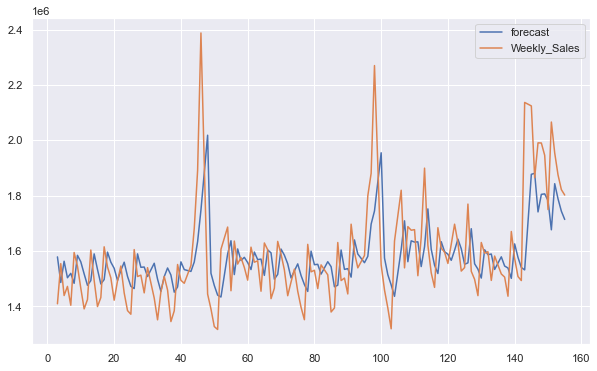

In [85]:
#then we could use the model to predict the future sales
model.plot_predict(dynamic=False)
plt.show()

In [86]:
model.forecast(5)#the first array gives the forecast of this model on the following 5 weeks' sales 

(array([1702999.15843849, 1649271.05720685, 1618803.7238645 ,
        1601569.99447325, 1591820.5662123 ]),
 array([153996.43682807, 174800.19396329, 180986.31003097, 182921.36009853,
        183536.33872276]),
 array([[1401171.68850798, 2004826.628369  ],
        [1306668.9725482 , 1991873.14186551],
        [1264077.07450901, 1973530.37322   ],
        [1243050.71667704, 1960089.27226946],
        [1232095.95246134, 1951545.17996325]]))